### Lab-102: Part-1
## Fairness considerations of credit loan decisions
In this case study, we focus on fairness in financial services, on mitigating gender-related performance disparities 
in financial lending decisions. Will explore "how Fairlearn could be used to measure
and mitigate unfairness in the loan adjudication process".

Using a dataset of credit loan outcomes (whether an individual defaulted on a credit loan), we train a fairness-unaware 
model to predict the likelihood an individual will default on a given loan. We use the Fairlearn toolkit for assessing 
the fairness of our model, according to several metrics. Finally, we perform two unfairness mitigation strategies on our 
model and compare the results to our original model.

Task: As a Persona, I would like to develop a classification model to predict whether an applicant will default on a 
    personal loan. A positive prediction by the model means the applicant would default on the credit loan. Defaulting 
    on a loan means the client fails to make payments within a 30-day window, and the lender can take legal actions 
    against the client.

In [46]:
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from fairlearn.metrics import (
    MetricFrame,
    count,
    equalized_odds_difference,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import EqualizedOdds, ExponentiatedGradient

warnings.simplefilter("ignore")

rand_seed = 1234
np.random.seed(rand_seed)

In [49]:
import pandas as pd

# Read CSV file from a folder
file_path = 'default of credit card clients.csv'
data = pd.read_csv(file_path)
dataset=data.rename(columns={"PAY_0": "PAY_1", "default payment next month": "default"})
dataset.head(10)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


### Features Description
sex, education, marriage, age : demographic features

pay_0, pay_2, pay_3, pay_4, pay_5, pay_6 : repayment status (ordinal)

bill_amt1, bill_amt2, bill_amt3, bill_amt4, bill_amt5, bill_amt_6 :bill statement amount (Taiwan dollars)

pay_amt1, pay_amt2, pay_amt3, pay_amt4, pay_amt5, pay_amt6 :previous statement amount (Taiwan dollars)

default payment next month : default information (1 = YES, 0 = NO)

In [48]:
dataset.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

From the dataset description : We can see that there are three categorical features:
        
SEX: Sex of the applicant (as a binary feature)

EDUCATION: Highest level of education achieved by the applicant.

MARRIAGE: Marital status of the applicant.

In [50]:
categorical_features = ["SEX", "EDUCATION", "MARRIAGE"]

for col_name in categorical_features:
    dataset[col_name] = dataset[col_name].astype("category")

Y, A = dataset.loc[:, "default"], dataset.loc[:, "SEX"]
X = pd.get_dummies(dataset.drop(columns=["default", "SEX"]))

A_str = A.map({1: "male", 2: "female"})

Let's explore the dataset for any characteristics that may lead to fairness-related harms later on in the modeling process.
In particular, we will focus on the distribution of sensitive feature SEX and the target label default.

In [51]:
A_str.value_counts(normalize=True)

female    0.603733
male      0.396267
Name: SEX, dtype: float64

 Let’s explore the distribution of the loan default rate Y. We see that around 78% of individuals in the dataset do not 
 default on their credit loan.

In [52]:
Y.value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default, dtype: float64

Add synthetic noise that is related to the outcome and sex
For the purpose of this case study, we add a synthetic feature Interest that introduces correlation between the SEX label 
of an applicant and the default outcome. The purpose of this feature is to replicate outcome disparities present in the 
original dataset.

### This feature is drawn from a Gaussian distribution for computational simplicity.

In [56]:
X.loc[:, "Interest"] = np.random.normal(loc=2 * Y, scale=A)

#### Check if this will lead to disparity in naive model

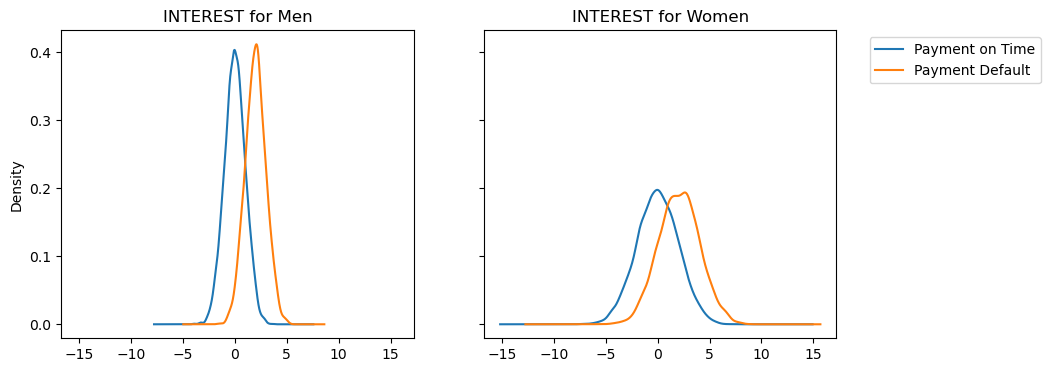

In [54]:
fig, (ax_1, ax_2) = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)
X["Interest"][(A == 1) & (Y == 0)].plot(
    kind="kde", label="Payment on Time", ax=ax_1, title="INTEREST for Men"
)
X["Interest"][(A == 1) & (Y == 1)].plot(kind="kde", label="Payment Default", ax=ax_1)
X["Interest"][(A == 2) & (Y == 0)].plot(
    kind="kde",
    label="Payment on Time",
    ax=ax_2,
    legend=True,
    title="INTEREST for Women",
)
X["Interest"][(A == 2) & (Y == 1)].plot(
    kind="kde", label="Payment Default", ax=ax_2, legend=True
).legend(bbox_to_anchor=(1.6, 1))

### Training an initial model

In [57]:
def resample_training_data(X_train, Y_train, A_train):
    """Down-sample the majority class in the training dataset to produce a
    balanced dataset with a 50/50 split in the predictive labels.

    Parameters:
    X_train: The training split of the features
    Y_train: The training split of the target labels
    A_train: The training split of the sensitive features

    Returns:
    Tuple of X_train, Y_train, A_train where each dataset has been re-balanced.
    """
    negative_ids = Y_train[Y_train == 0].index
    positive_ids = Y_train[Y_train == 1].index
    balanced_ids = positive_ids.union(np.random.choice(a=negative_ids, size=len(positive_ids)))

    X_train = X_train.loc[balanced_ids, :]
    Y_train = Y_train.loc[balanced_ids]
    A_train = A_train.loc[balanced_ids]
    return X_train, Y_train, A_train

In [58]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, Y, A_str, test_size=0.35, stratify=Y
)

X_train, y_train, A_train = resample_training_data(X_train, y_train, A_train)

At this stage, we will train a gradient-boosted tree classifier using the lightgbm package on the balanced training dataset. When we evaluate the model, we will use the unbalanced testing dataset.

In [59]:
lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.03,
    "num_leaves": 10,
    "max_depth": 3,
    "random_state": rand_seed,
    "n_jobs": 1,
    "verbose": -1,
}

estimator = Pipeline(
    steps=[
        ("preprocessing", StandardScaler()),
        ("classifier", lgb.LGBMClassifier(**lgb_params)),
    ]
)

estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc',
                                n_jobs=1, num_leaves=10, objective='binary',
                                random_state=1234, verbose=-1))])

In [60]:
Y_pred_proba = estimator.predict_proba(X_test)[:, 1]
Y_pred = estimator.predict(X_test)

From the ROC Score, we see the model appears to be differentiating between true positives and false positives well. This is to be expected given the INTEREST feature provides a strong discriminant feature for the classification task.

In [61]:
roc_auc_score(y_test, Y_pred_proba)

0.8702804781278358

### Feature Importance of the Unmitigated Classifier

<Axes: title={'center': 'Feature Importance'}, xlabel='Feature importance', ylabel='Features'>

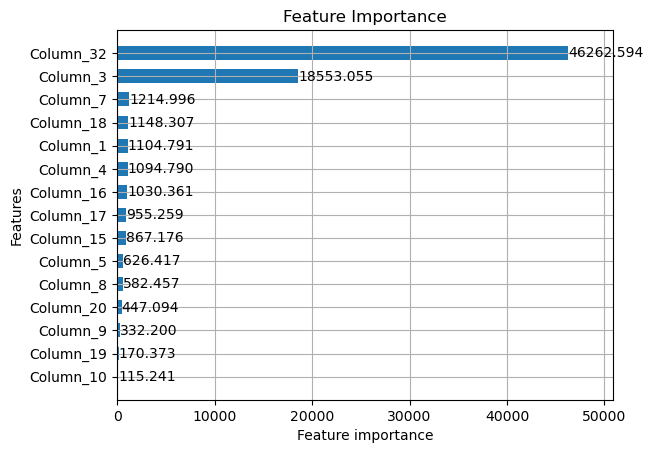

In [62]:
lgb.plot_importance(
    estimator.named_steps["classifier"],
    height=0.6,
    title="Feature Importance",
    importance_type="gain",
    max_num_features=15,
)

## Fairness assessment of unmitigated model
we have trained our initial fairness-unaware model, let’s perform our fairness assessment for this model. When conducting a fairness assessment, there are three main steps we want to perform:

### Identify who will be harmed.

### Identify the types of harms we anticipate.

### Define fairness metrics based on the anticipated harms.
Now that we have identified the relevant harms we anticipate users will experience, we can define our fairness metrics.
In addition to the metrics, we will quantify the uncertainty around each metric using custom functions to compute the 
standard error for each metric at the confidence level.

In [72]:
#Define fairness metrics based on the anticipated harms.

def compute_error_metric(metric_value, sample_size):
    """Compute standard error of a given metric based on the assumption of
    normal distribution.

    Parameters:
    metric_value: Value of the metric
    sample_size: Number of data points associated with the metric

    Returns:
    The standard error of the metric
    """
    metric_value = metric_value / sample_size
    return 1.96 * np.sqrt(metric_value * (1.0 - metric_value)) / np.sqrt(sample_size)


def false_positive_error(y_true, y_pred):
    """Compute the standard error for the false positive rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fp, tn + fp)


def false_negative_error(y_true, y_pred):
    """Compute the standard error for the false negative rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fn, fn + tp)


def balanced_accuracy_error(y_true, y_pred):
    """Compute the standard error for the balanced accuracy estimate."""
    fpr_error, fnr_error = false_positive_error(y_true, y_pred), false_negative_error(
        y_true, y_pred
    )
    return np.sqrt(fnr_error**2 + fpr_error**2) / 2


fairness_metrics = {
    "count": count,
    "balanced_accuracy": balanced_accuracy_score,
    "balanced_acc_error": balanced_accuracy_error,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "false_positive_error": false_positive_error,
    "false_negative_rate": false_negative_rate,
    "false_negative_error": false_negative_error,
}

In [73]:
metrics_to_report = [
    "balanced_accuracy",
    "false_positive_rate",
    "false_negative_rate",
]

#### Instantiate the MetricFrame for the unmitigated model

In [74]:
metricframe_unmitigated = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=Y_pred,
    sensitive_features=A_test,
)

metricframe_unmitigated.by_group[metrics_to_report]

metricframe_unmitigated.difference()[metrics_to_report]

metricframe_unmitigated.overall[metrics_to_report]

balanced_accuracy      0.792933
false_positive_rate     0.21267
false_negative_rate    0.201464
dtype: object

In [75]:
def plot_group_metrics_with_error_bars(metricframe, metric, error_name):
    """Plot the disaggregated metric for each group with an associated
    error bar. Both metric and the error bar are provided as columns in the
    provided MetricFrame.

    Parameters
    ----------
    metricframe : MetricFrame
        The MetricFrame containing the metrics and their associated
        uncertainty quantification.
    metric : str
        The metric to plot
    error_name : str
        The associated standard error for each metric in metric

    Returns
    -------
    Matplotlib Plot of point estimates with error bars
    """
    grouped_metrics = metricframe.by_group
    point_estimates = grouped_metrics[metric]
    error_bars = grouped_metrics[error_name]
    lower_bounds = point_estimates - error_bars
    upper_bounds = point_estimates + error_bars

    x_axis_names = [str(name) for name in error_bars.index.to_flat_index().tolist()]
    plt.vlines(
        x_axis_names,
        lower_bounds,
        upper_bounds,
        linestyles="dashed",
        alpha=0.45,
    )
    plt.scatter(x_axis_names, point_estimates, s=25)
    plt.xticks(rotation=0)
    y_start, y_end = np.round(min(lower_bounds), decimals=2), np.round(
        max(upper_bounds), decimals=2
    )
    plt.yticks(np.arange(y_start, y_end, 0.05))
    plt.ylabel(metric)

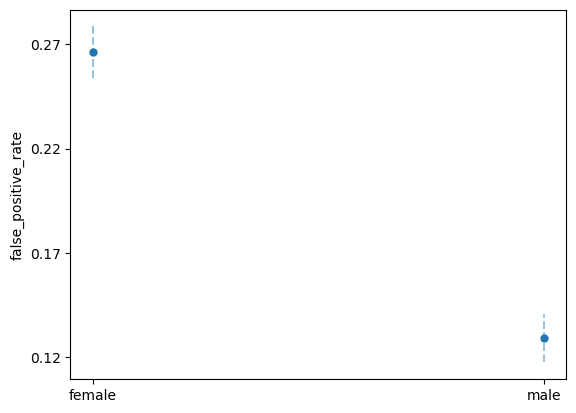

In [76]:
plot_group_metrics_with_error_bars(
    metricframe_unmitigated, "false_positive_rate", "false_positive_error"
)

array([[<Axes: title={'center': 'balanced_accuracy'}, xlabel='SEX'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='SEX'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='SEX'>]],
      dtype=object)

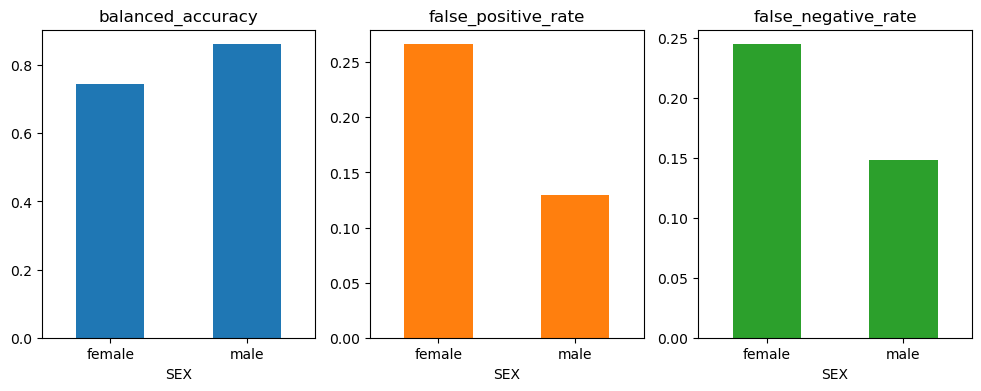

In [77]:
metricframe_unmitigated.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

In our lending context, both false_negative_rate_disparities and false_positive_rate_disparities result in 
fairness-related harms. Therefore, we attempt to minimize both of these metrics by minimizing the 
equalized_odds_difference.

In [80]:
balanced_accuracy_unmitigated = balanced_accuracy_score(y_test, Y_pred)
equalized_odds_unmitigated = equalized_odds_difference(y_test, Y_pred, sensitive_features=A_test)

#### Mitigating Unfairness in ML models
we will explore strategies for mitigating the performance disparities we found in our unmitigated model. 
We will apply one different mitigation strategies:

#### Postprocessing: In the postprocessing approach, the outputs of a trained classifier are transformed to satisfy some fairness criterion.

Reductions: In the reductions approach, we take in a model class and iteratively create a sequence of models that optimize some fairness constraint. Compared to the postprocessing approach, the fairness constraint is satisfied during the model training time rather than afterwards.

In [81]:
#Postprocessing mitigations: ThresholdOptimizer

postprocess_est = ThresholdOptimizer(
    estimator=estimator,
    constraints="equalized_odds",  # Optimize FPR and FNR simultaneously
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method="predict_proba",
)

In [82]:
postprocess_est.fit(X=X_train, y=y_train, sensitive_features=A_train)

postprocess_pred = postprocess_est.predict(X_test, sensitive_features=A_test)

postprocess_pred_proba = postprocess_est._pmf_predict(X_test, sensitive_features=A_test)

#### Fairness assessment of postprocessing model

In [83]:
def compare_metricframe_results(mframe_1, mframe_2, metrics, names):
    """Concatenate the results of two MetricFrames along a subset of metrics.

    Parameters
    ----------
    mframe_1: First MetricFrame for comparison
    mframe_2: Second MetricFrame for comparison
    metrics: The subset of metrics for comparison
    names: The names of the selected metrics

    Returns
    -------
    MetricFrame : MetricFrame
        The concatenation of the two MetricFrames, restricted to the metrics
        specified.

    """
    return pd.concat(
        [mframe_1.by_group[metrics], mframe_2.by_group[metrics]],
        keys=names,
        axis=1,
    )

In [84]:
bal_acc_postprocess = balanced_accuracy_score(y_test, postprocess_pred)
eq_odds_postprocess = equalized_odds_difference(
    y_test, postprocess_pred, sensitive_features=A_test
)

metricframe_postprocess = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=postprocess_pred,
    sensitive_features=A_test,
)

metricframe_postprocess.overall[metrics_to_report]

metricframe_postprocess.difference()[metrics_to_report]

balanced_accuracy       0.02647
false_positive_rate    0.040726
false_negative_rate    0.012214
dtype: object

Now, let’s compare the performance of our thresholded classifier with the original unmitigated model.

array([[<Axes: title={'center': 'balanced_accuracy'}, xlabel='SEX'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='SEX'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='SEX'>]],
      dtype=object)

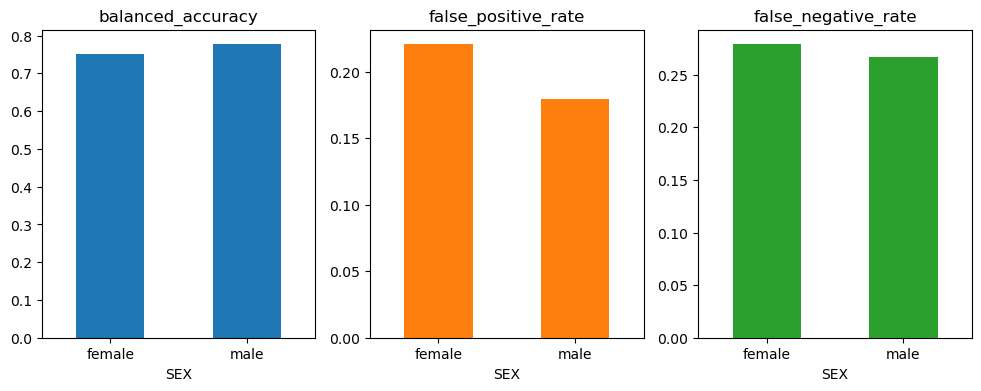

In [85]:
compare_metricframe_results(
    metricframe_unmitigated,
    metricframe_postprocess,
    metrics=metrics_to_report,
    names=["Unmitigated", "PostProcess"],
)

metricframe_postprocess.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

#### Conclusion and Discussion
In this case study, we walked through the process of assessing a credit decision model for gender-related performance 
disparities.Yet We havn't applied a postprocessing and reductions mitigation techniques to mitigate the equalized odds 
difference in our model.
We applied a postprocessing to mitigate the equalized odds difference in our model.
Through the reductions process, we generated a model that reduces the equalized odds difference of the original model 
without a drastic increase in the balanced error score. If this were a real model being developed a financial institution, 
the balanced error score would be a proxy for the profitability of the model. By maintaining a relatively similar balanced
error score, we’ve produced a model that preserves profitability to the firm while producing more fair and equitable 
outcomes for women in this scenario.

Next Steps to explore:
    Mitigating Unfairness in ML models
    Reductions approach to unfairness mitigation